In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',100)
sns.set(style = 'white', context = 'notebook', palette = 'deep')
sns.set_style('white')
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体

path1 = './data-firstround'
op_train = pd.read_csv('./data/operation_pre.csv',encoding='gbk')
tr_train = pd.read_csv('./data/transaction_pre.csv', encoding='gbk')
tag_train = pd.read_csv(path1 + '/tag_train_new.csv')
op_train = op_train.merge(tag_train,on=['UID'],how='left')
op_train = op_train[op_train['Tag'].notnull()]
tr_train = tr_train.merge(tag_train,on=['UID'],how='left')
tr_train = tr_train[tr_train['Tag'].notnull()]



C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 数据集重合情况
训练集中同时有操作和交易的用户有29091个，只有操作记录的用户有637个，只有交易记录的用户有1451个。

In [119]:
len(np.intersect1d(op_train['UID'],tr_train['UID']))

29091

In [120]:
op_train['UID'].nunique()

29728

In [121]:
tr_train['UID'].nunique()

30542

### 用户操作数据

In [12]:
# 羊毛党想要通过最少的成本获取最大的利益，所以会有这样的显著差异
print('黑产用户平均操作次数:',int(op_train[op_train.Tag == 1].groupby('UID').size().agg('mean')))
print('正常用户平均操作次数:',int(op_train[op_train.Tag == 0].groupby('UID').size().agg('mean')))

黑产用户平均操作次数: 36
正常用户平均操作次数: 51


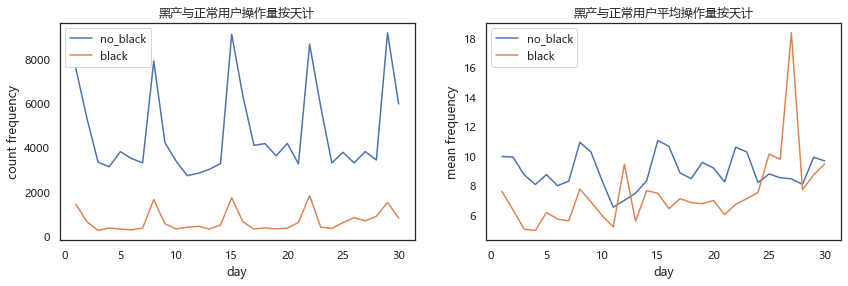

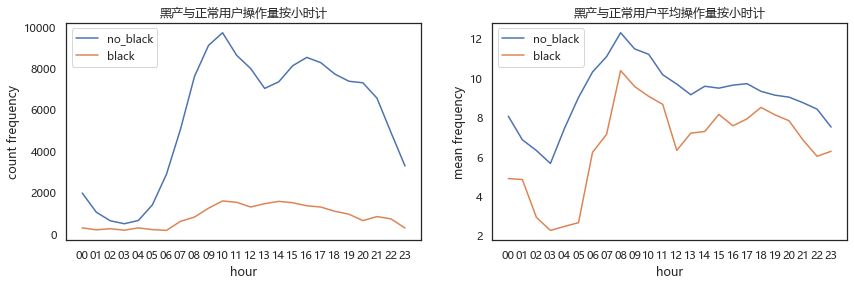

In [159]:
def countfig(data,col,timename,strname):
    plt.figure(figsize = [14, 4])
    plt.subplot(1,2,1)
    plt.plot(data[data.Tag==0].groupby(col)['UID'].nunique())
    plt.plot(data[data.Tag==1].groupby(col)['UID'].nunique())
    plt.xlabel(col)
    plt.ylabel('count frequency')
    plt.legend(['no_black','black'],loc = 'upper left');
    plt.title('黑产与正常用户{}量按{}计'.format(strname,timename));

    plt.subplot(1,2,2)
    for i in [0,1]:
        a = data[data.Tag==i][[col,'UID']]
        a['count'] = 1
        plt.plot(a.groupby([col,'UID'])['count'].count().groupby(col).agg('mean'))
    plt.xlabel(col)
    plt.ylabel('mean frequency')
    plt.legend(['no_black','black'],loc = 'upper left');
    plt.title('黑产与正常用户平均{}量按{}计'.format(strname,timename));

countfig(op_train,'day','天','操作')
countfig(op_train,'hour','小时','操作')

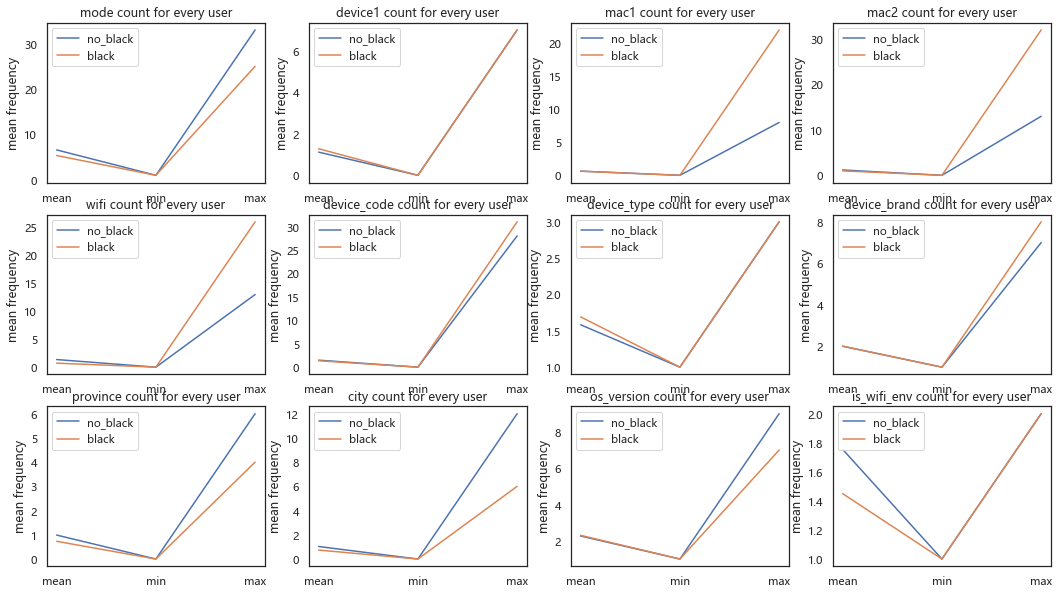

In [138]:
def colcountplot(data,col):
    for i in [0,1]:
        plt.plot(data[data.Tag==i].groupby("UID")[col].nunique().agg(['mean','min','max']));
    plt.ylabel('mean frequency')
    plt.legend(['no_black','black'],loc = 'upper left');
    plt.title('{} count for every user'.format(col))

featurecols = ['mode','device1','mac1','mac2','wifi','device_code','device_type','device_brand', \
               'province','city','os_version','is_wifi_env']   

plt.figure(figsize = [18, 10])
for i,col in enumerate(featurecols):   
    plt.subplot(3,4,i+1)
    colcountplot(op_train,col)

In [185]:
featurecols = ['mode','device1','mac1','mac2','wifi','device_code','device_type','device_brand','os_version']   
for col in featurecols:
    a = pd.DataFrame(op_train[op_train.Tag==1].groupby(col)['UID'].count()).reset_index().\
                                                    sort_values(by='UID',ascending=False).head(5)
    b = pd.DataFrame(op_train[op_train.Tag==0].groupby(col)['UID'].count()).reset_index().\
                                                    sort_values(by='UID',ascending=False).head(5)
    print('{}:黑产用户和正常用户共有类型为{}'.format(col,len(np.intersect1d(a[col],b[col]))))

mode:黑产用户和正常用户共有类型为5
device1:黑产用户和正常用户共有类型为4
device2:黑产用户和正常用户共有类型为1
mac1:黑产用户和正常用户共有类型为1
mac2:黑产用户和正常用户共有类型为1
wifi:黑产用户和正常用户共有类型为0
device_code:黑产用户和正常用户共有类型为0
device_type:黑产用户和正常用户共有类型为3
device_brand:黑产用户和正常用户共有类型为4
os_version:黑产用户和正常用户共有类型为4


### 用户交易数据

In [187]:
print('黑产用户平均交易次数:',int(tr_train[tr_train.Tag == 1].groupby('UID').size().agg('mean')))
print('正常用户平均交易次数:',int(tr_train[tr_train.Tag == 0].groupby('UID').size().agg('mean')))

黑产用户平均交易次数: 11
正常用户平均交易次数: 8


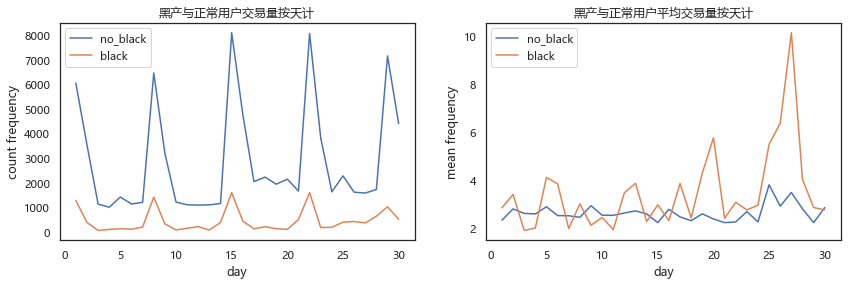

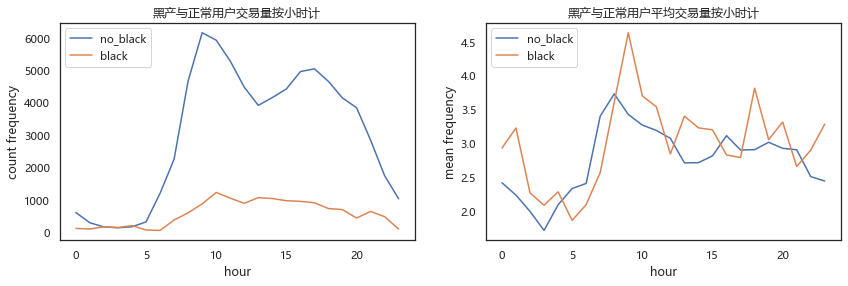

In [189]:
countfig(tr_train,'day','天','交易')
countfig(tr_train,'hour','小时','交易')

In [8]:
##channel
print('黑产用户channel的平均种类：',tr_train[tr_train.Tag==1].groupby("UID")['channel'].nunique().agg('mean'))
print('正常用户channel的平均种类：',tr_train[tr_train.Tag==0].groupby("UID")['channel'].nunique().agg('mean'))

黑产用户channel的平均种类： 1.7252692211369898
正常用户channel的平均种类： 1.2999359674564013


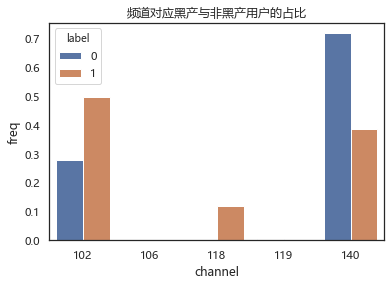

In [41]:
L3 = pd.DataFrame(tr_train[tr_train.Tag==1].groupby('channel')['UID'].count()).rename(columns={'UID':'freq'})
L3 = L3/L3.sum()
L4 = pd.DataFrame(tr_train[tr_train.Tag==0].groupby('channel')['UID'].count()).rename(columns={'UID':'freq'})
L4 = L4/L4.sum()
L3['label'] = 1
L4['label'] = 0
L = pd.concat([L3,L4],axis=0).reset_index()

sns.barplot(x='channel',y='freq',data=L,hue='label');
plt.title('频道对应黑产与非黑产用户的占比');

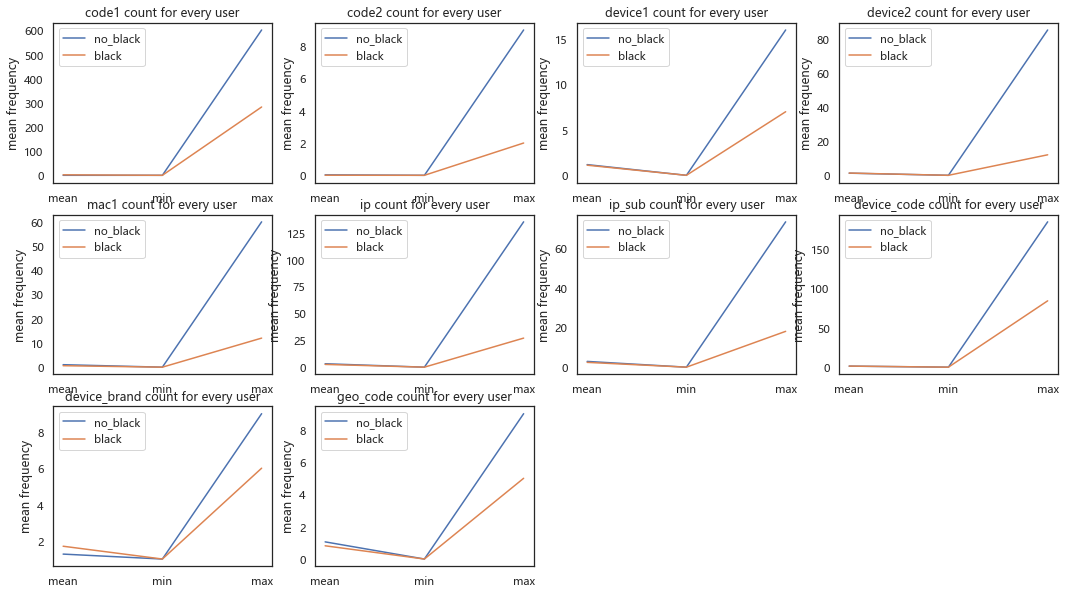

In [47]:
featurecols = ['code1', 'code2','device1', 'device2','mac1', 'ip','ip_sub','device_code','device_brand','geo_code']   

plt.figure(figsize = [18, 10])
for i,col in enumerate(featurecols):   
    plt.subplot(3,4,i+1)
    colcountplot(tr_train,col)

In [55]:
pd.DataFrame({"羊毛党金额":tr_train[tr_train.Tag==1]['trans_amt'].describe(),
             "用户金额":tr_train[tr_train.Tag==0]['trans_amt'].describe()}).astype('int64')

,羊毛党金额,用户金额
count,44982,219672
mean,8390,38697
std,65928,531679
min,102,102
25%,102,1459
50%,2736,2818
75%,2818,5264
max,2990210,111069095


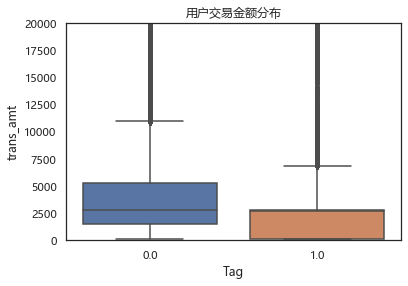

In [8]:
sns.boxplot(data = tr_train,y = 'trans_amt',x='Tag');
plt.ylim(0,20000);
plt.title('用户交易金额分布');

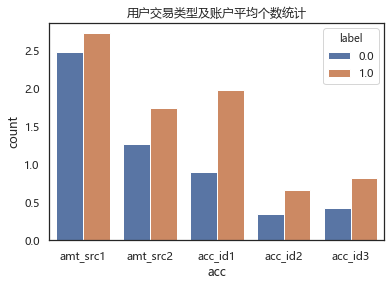

In [131]:
#用户交易类型及账户
cols = ['amt_src1','amt_src2','acc_id1','acc_id2','acc_id3']
account1 = np.ones((len(cols),2))
account2 = np.ones((len(cols),2))
for i,col in enumerate(cols):
    account1[i] = [tr_train[tr_train.Tag==1].groupby("UID")[col].nunique().agg('mean'),1]
    account2[i] = [tr_train[tr_train.Tag==0].groupby("UID")[col].nunique().agg('mean'),0]
account1 = pd.DataFrame(account1).rename(columns={0:'count',1:'label'})
account2 = pd.DataFrame(account2).rename(columns={0:'count',1:'label'})
account1['acc'] = cols
account2['acc'] = cols
account = pd.concat([account1,account2],axis=0)

sns.barplot(x='acc',y='count',data=account,hue='label');
plt.title('用户交易类型及账户平均个数统计');

In [134]:
##merchant
featurecols = ['merchant']   
for col in featurecols:
    a = pd.DataFrame(tr_train[tr_train.Tag==1].groupby(col)['UID'].count()).reset_index().\
                                                    sort_values(by='UID',ascending=False).head(5)
    b = pd.DataFrame(tr_train[tr_train.Tag==0].groupby(col)['UID'].count()).reset_index().\
                                                    sort_values(by='UID',ascending=False).head(5)
    print('{}:黑产用户和正常用户共有类型为{}'.format(col,len(np.intersect1d(a[col],b[col]))))

merchant:黑产用户和正常用户共有类型为0


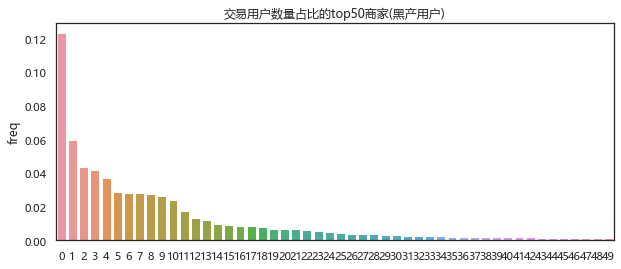

In [171]:
a = pd.DataFrame(tr_train[tr_train.Tag==1].groupby('merchant')['UID'].count()).reset_index().\
                                                    sort_values(by='UID',ascending=False)
a['freq'] = a['UID']/a['UID'].sum()

plt.figure(figsize=[10,4])
sns.barplot(x=list(range(0,50)),y='freq',data=a.head(50));
plt.title('交易用户数量占比的top50商家(黑产用户)');

In [158]:
b = pd.DataFrame(tr_train[tr_train.Tag==0].groupby('merchant')['UID'].count()).reset_index().\
                                                    sort_values(by='UID',ascending=False)
b['freq'] = b['UID']/b['UID'].sum()

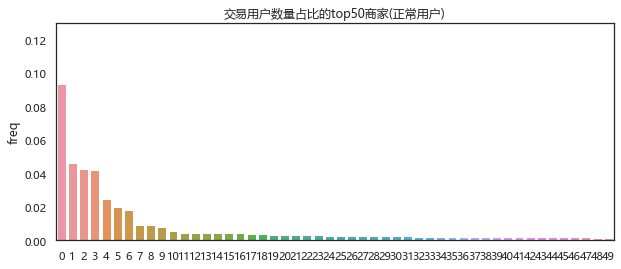

In [170]:
plt.figure(figsize=[10,4])
sns.barplot(x=list(range(0,50)),y='freq',data=b.head(50));
plt.ylim(0,0.13);
plt.title('交易用户数量占比的top50商家(正常用户)');

In [130]:
#账户余额
pd.DataFrame({"羊毛党余额":tr_train[tr_train.Tag==1]['bal'].describe(),
             "用户余额":tr_train[tr_train.Tag==0]['bal'].describe()}).astype('int64')

,羊毛党余额,用户余额
count,44982,219672
mean,15457,48487
std,136088,699657
min,100,100
25%,100,100
50%,100,100
75%,273,100
max,3144526,31771772


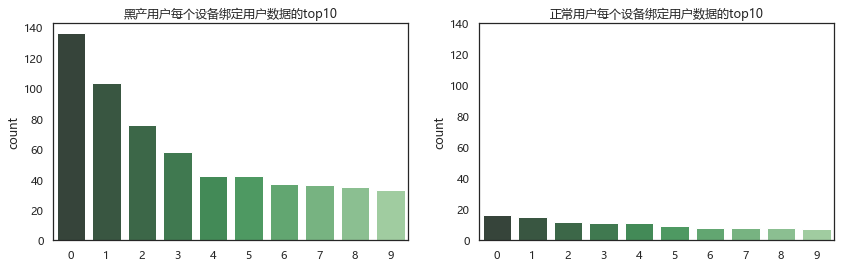

In [192]:
##黑产一个设备绑定了多个账户
a = pd.DataFrame(tr_train[tr_train.Tag==1].groupby('device_code')['UID'].nunique()).reset_index().\
                                                    sort_values(by='UID',ascending=False).rename(columns={'UID':'count'})
b=pd.DataFrame(tr_train[tr_train.Tag==0].groupby('device_code')['UID'].nunique()).reset_index().\
                                                    sort_values(by='UID',ascending=False).rename(columns={'UID':'count'})

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
sns.barplot(x=list(range(0,10)),y='count',data=a.head(10),palette = 'Greens_d');
plt.title('黑产用户每个设备绑定用户数据的top10');

plt.subplot(1,2,2)
sns.barplot(x=list(range(0,10)),y='count',data=b.head(10),palette = 'Greens_d');
plt.ylim(0,140);
plt.title('正常用户每个设备绑定用户数据的top10');